 # ** NAqsec: a simulation tool for error correction codes in NAQC **

The aim of NAqsec is to be able to construct logical circuits using QEC schemes, compile them in a set of specific instructions for NA platforms and simulate the under noisy conditions. 


## Circuit construction

For that first of all we must construct the cirucits:

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.qasm3 import dumps, loads

# Import the constructing functions
from simulation_utils import logic_NA_prep, logic_circuit, logic_CSS_prep_ft, logic_CSS_prep_ft_reuse

# Import codes from QECC
from mqt.qecc import CSSCode
from mqt.qecc.codes import HexagonalColorCode, SquareOctagonColorCode

c:\Users\josep\anaconda3\envs\tfg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First the error correction scheme must be chosen. Let's choose the well-known Shor's algorithm

In [2]:
CSS_name = "Shor" 
code = CSSCode.from_code_name(CSS_name) # initalize CSS code
states = [True] #logical qubit initialization. True is the 0 logical, False is the + logical.

Now, we have to choose the corresponding logical circuit : a simple qubit initalization will be enough to show how everything works.

If larger circuits are desired, it's easy: just build your QuantumCircuit from Qiksit and assign the initalization of each qubit in the list states (be aware that not all codes allow all logical gates)

In [3]:
my_circuit = QuantumCircuit(0)

We choose the name of the file where we want to save the circuit, and choose to also optimize for depth during circuit construction

In [4]:
optimize_depth = True
name = "circuit_data/shor_0_full_ft.qasm" # desired name of the circuit

Now it's time to construct the circuit. For that we will first build the logical circuit and then translate it to NA native gates.

Here we used the full fault-tolerant state preparation circuits and the heuristic alogirthms while ancilla qubits are NOT being reused for the different syndrome extraction rounds.

In [5]:
prep_circ_qasm, prep_circ_obj, circuit_data = logic_CSS_prep_ft(code, states, fault_tolerant = True, logic_qiskit = my_circuit)
na_circ = logic_NA_prep(prep_circ_qasm, file_name = name)

The functions return a circuit object and the necessary data to properly reconstruct the STIM circuit. Now, the data needs to be saved in a .txt file

In [6]:
name_data = "circuit_data/shor_0_full_ft_data.txt" #desired name of the data
with open(name_data, "w") as f:
    f.write(str(circuit_data))

## Circuirt Compilation

Once we have constructed the circuit, we need to compile it. For that we will use the ZONED ARCHITECTURE NA compiler from MQT_QMAP.

This should be included within the pip distribution (please see the original repository for more information) but at the moment this was written, the tool had to be build on ones computer.
In the case of the latter, the following instructions should be contained in the same parent folder as the tool together with the architecture and setting files. 

NOTE: Simulating circuits with reused ancillas should can only be done building on a specific mqt-qmap branch.

In [7]:
from mqt.core import load
from mqt.qmap.na.zoned import RoutingAwareCompiler, ZonedNeutralAtomArchitecture

We take the settings / architecture and compile and initalize the class.

In [8]:
arch = ZonedNeutralAtomArchitecture.from_json_file("mqt-qmap-tobebuilt/architecture.json")

# load the settings
with open("mqt-qmap-tobebuilt/settings.json", "r") as file:
    settings = file.read()

# create compiler
compiler = RoutingAwareCompiler.from_json_string(arch, settings)

Next, the circuit file is loaded (optinally, not necessary if in same file), and compiled. The instructions are saved in a .naviz file under the same name

In [9]:
qc = load("circuit_data/shor_0_full_ft.qasm") #desired name
result = compiler.compile(qc)
naviz_name = "circuit_data/shor_0_full_ft.naviz"
# write result to file
with open(naviz_name, "w") as file:
    file.write(result)

Optinally, although NAqsec should detect the unitary gate representation of X and H gates, one can esaily change them beforehand

In [10]:
with open(naviz_name, "r") as file:
     content = file.read()
content = content.replace("u 1.57080 0.00000 3.14159", "h")
content = content.replace("u 3.14159 0.00000 3.14159", "x")

# # overwrite the file with the modified content
with open(naviz_name, "w") as file:
     file.write(content)

## Simulation

Finally, with the given instruction is time to simulate the circuit and see the results!!

For that the two main classes of NAqsec will be used: NAdecoder and Convert2STIM

In [11]:
from NA_decoder import NAdecoder
import numpy as np
from scipy.io import savemat
from mqt.qecc import CSSCode
from simulation_utils import add_error_functions
import time
import yaml

If not in the same file, which sometimes it may result more convenient, first the circuit_data and .naviz files must be loaded

In [12]:
circuit_name_info = "shor_0_full_ft"
name_data = "circuit_data/{}_data.txt".format(circuit_name_info)
with open(name_data, "r") as f:
    circuit_data = eval(f.read()) 
print(circuit_data)
#----------------------- AZAC routing --------------------------

name = 'circuit_data/{}.naviz'.format(circuit_name_info) #CHANGE PATH IF NECESSARY
with open( name , 'r') as file:
    compiled_circ = file.read()


([2], [2], [31], 2, False)


We define some parameteres of the simulation, including the architecture set up extracted from the .json file and the desired noise_rates

In [13]:
dist_max = 2 # usually the standard paramter, can be double checked in architecture file of router
cz_zone = [(30, 302),(270, 372)] # read from architecture file of router

noise_levels = np.logspace(-3, -2, 3) # desired noise values 

We have to choose and built the desired error model. In the folder error_model there are already a few ready to get tested, but you can design one on your own too ! 

In this case we choose the error_model named "standard-depolarizing", that as its name indiccates, implements depolarizing noise after every gate!

In [14]:
error_model_name = "standard_depolarizing" 
error_dict_name = 'error_models/{}/error_channels.yaml'.format(error_model_name) #import desired error model from the folder error_models in the same parent folder
with open(error_dict_name, "r") as f:
    error_model = yaml.safe_load(f)

error_model = add_error_functions(error_model_name, error_model) #join dictionary and auxiliary functions

We first have to initialize the NAdecoder class, which builds the Lookup Table, so for large instances codes it may took a while. We start the counter to asses the duration of the whole simulation process.

In [15]:
start = time.time()
decoder_na = NAdecoder(code, states, compiled_circ, circuit_data, cz_zone, dist_max)

Afterwards, we start simulation with the *benchmark* method. This requires multiple parameteres, such as the error rates, the list of quibits to initialize, the error model, the size of each batch, wheter to simulate until a minimum
amount of errors is sampled and how many, if the decoding of different logical observers is done separately or joint, or parameters for parallel execution.

error rate [8.48856612e-05] [76.] [104678.] 1
error rate [0.000765] [540.] [294114.] 1
error rate [0.00805627] [2741.] [659768.] 1
Execution time: 2.1753 minutes


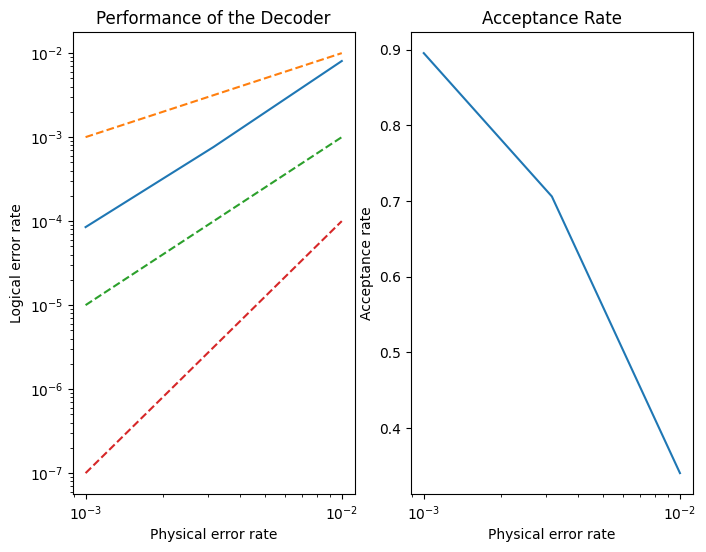

In [16]:
logic_errors, acceptance_rate = decoder_na.benchmark(noise_levels, states, error_model, nb_shots = 1_000_000, at_least_min_errors= True, min_errors = 30, joint_decoding = False, parallel_execution = False, num_cores = 1)

end = time.time()
elapsed = (end - start) / 60
print(f"Execution time: {elapsed:.4f} minutes")


Once simulated, we can save the results in the most desired format but we can take a first look by looking at the already generated image. During simulation, the text file of the circuit and its image have also been stored.

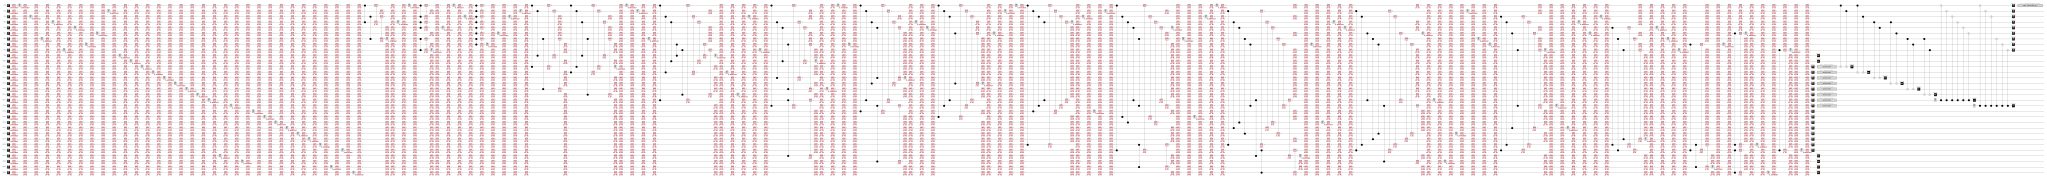

In [26]:
import stim
with open('stim_circ.stim', 'r') as f:
    stim_circ = stim.Circuit(f.read())

# Now you can use stim_circ as a Stim circuit object
stim_circ.diagram('timeline-svg')